# Part A: Probabilistic Gaussian Generative Classifier

**A1. Dataset and Setup**


used to import the dataset

In [ ]:
from sklearn.datasets import load_digits              #to load dataset
from sklearn.model_selection import train_test_split  #to split data
from sklearn.preprocessing import StandardScaler      #to standardize the features

**loaded digits:**

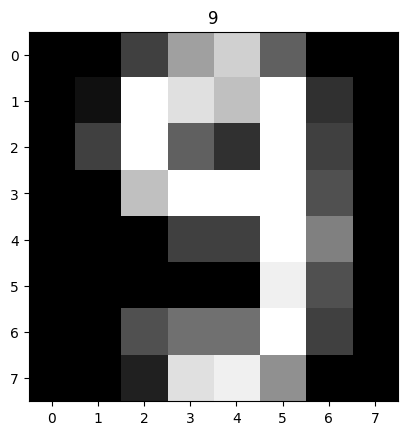

((1797,), array([0, 1, 2, ..., 8, 9, 8]), np.int64(9))

In [ ]:
digits = load_digits()
X=digits.data
X.shape
Y=digits.target
import matplotlib.pyplot as plt
plt.imshow(digits.images[1792], cmap='gray')
plt.title(digits.target[1792])
plt.show()
# .images shape (1797,8,8) each datapoint is 8x8 image of a digit
# .data is flattened image (1797,64) 64 features with values from 0-16 (intensity: greyscale)
Y.shape,Y,Y[1792]


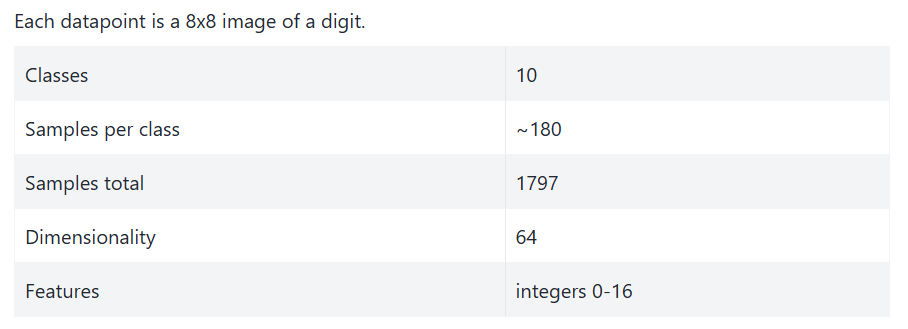  
link:

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

**Splitting:**

In [ ]:
x_train,x_temp,y_train,y_temp = train_test_split(
    X,Y,train_size=0.7,random_state=42,shuffle=True,stratify=Y
)                               #temp -> 540 samples (30%)
                                #with stratify we get 70% of each class
x_valid,x_test,y_valid,y_test = train_test_split(
    x_temp,y_temp,train_size=0.5,random_state=42,stratify=y_temp
)
x_valid.shape                   #270 which is 15% of 1797

(270, 64)

In [ ]:
x_train.shape # 1257 ->70% of 1797

(1257, 64)

**shuffle** -> to make sure that the classes are randomly mixed which makes the train set contain all the classes
Prevents the problem of having all samples of certain classes grouped together, which could lead to some splits missing certain classes in train, validation, or test sets.

**stratify** -> to make sure that the proportion of each digit class is similar in all three sets.
for example label 5 we have 10% of the dataset it will make 10% in each split

**random state** -> to make sure we are having the same order and same splits everytime
the same seed everytime we run (42) which makes the shuffling deterministic ... the sets are reproducible


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
import numpy as np

# Count samples per class
#bincount ->count the occurrances of each digit
print("Train class counts:", np.bincount(y_train))
print("Validation class counts:", np.bincount(y_valid))
print("Test class counts:", np.bincount(y_test))

Train class counts: [124 127 124 128 127 127 127 125 122 126]
Validation class counts: [27 27 27 27 27 28 27 27 26 27]
Test class counts: [27 28 26 28 27 27 27 27 26 27]


**standardize the features (for example, using StandardScaler from scikit-learn).**

In [ ]:
scaler = StandardScaler()     #instantiating an object of the scaler
# fit on training data
scaler.fit(x_train)
# transform train, validation and test sets
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test  = scaler.transform(x_test)

**A2. Gaussian Generative Model**

In [ ]:
num_ofClasses = 10 # 0 - 9
num_features = x_train.shape[1] # 64 features (8*8)
# num_samples = x_train.shape[0]  # 1257 samples (the training samples only)

**1. Learning the model that will model each class (multivariate gaussian distribution representing each class)**

By learning a model for each class I mean we will be modeling each class with a multivariate gaussian distribution and **learing** actually means learning the parameters that define that multivariate gaussian (μ,Σ) mean and covariance (the spread (diagonal-> variance of each class) and correlation between the features) for each class

**How do we learn the parameter?**
Well, we use the **maximum likelihood** estimation (which quantifies how good the distribution actually fits the data) by maximizing the likelihood we are getting the parameters which fits the data the best (it's more like we are estimating the parameters that made that data we observed distributed in that way)

**as well as learing the prior of each class**

## 1. Class Prior

$$P(C_k) = \frac{n_k}{n}$$


**Where:**
- $n_k$ = number of samples in class k
- $n$ = total number of samples
- $C_k$ = class k

1. Estimate the class priors π_k:


• For each class k, count how many training samples belong to that class.

• π_k = (number of training samples in class k) / (total number of training samples)

In [ ]:
#passing y_train if we will train train set and combined if we will retrain on combined
def estimate_Prior(y,num_samples):
  # STEP 1: Estimate the class prior
  priorOfclass = np.zeros(num_ofClasses)
  #intializing the prior to be 0 for the 10 classes we have

  #looping over all classes to get their prior (by counting
  #the sample points that were classified to be of class k/all the samples we have)

  for k in range(num_ofClasses):
    priorOfclass[k] = np.sum(y == k) / num_samples
  return priorOfclass

**defining some syntax**

**np.sum(condition)**

the condition creates a boolean array of true or false (1,0) then sum will be adding all of the vector giving us the count of 1's which means the count of the samples from the training data who is classified as class k

## 2. Maximum Likelihood Estimate of Mean

**Class-conditional (per class k):**
$$\hat{\boldsymbol{\mu}}_k = \frac{1}{n_k} \sum_{i: y_i = k} \mathbf{x}_i$$

Where:
- $n_k$ = number of samples in class $k$
- $\mathbf{x}_i$ = feature vector for sample $i$

2. Estimate the class means μ_k:

• For each class k, compute the average of all training samples with label k.

• This gives one 64-dimensional mean vector for each digit class.

In [ ]:
#passing x_train,y_train or x_combined,y_combined
def estimate_mean(x,y):
  #STEP 2: Estimate class means
  meanOfClass=np.zeros((num_ofClasses,num_features)) #10 arrays each of size 64 (mean of each feature)
  for k in range(num_ofClasses):
    x_inClass_k = x[y == k]
    meanOfClass[k]=np.mean(x_inClass_k, axis=0)
  meanOfClass[0].shape #checking each mean should be d*1 (64*1)
  return meanOfClass

# **Syntax:**


## Boolean Indexing (Masking) in NumPy

### How `X_train[y_train == k]` works

This uses **boolean indexing** to filter rows based on a condition.

---

### Step 1: Create a Boolean Mask
```python
y_train = np.array([0, 1, 0, 2, 1, 0, 2])
k = 0

mask = (y_train == k)
print(mask)  # [True, False, True, False, False, True, False]
```

The comparison `y_train == k` creates a **boolean array** of the same length.

---

### Step 2: Use Mask to Filter Rows
```python
X_train = np.array([[1, 2],    # sample 0, class 0 ✓
                     [3, 4],    # sample 1, class 1 ✗
                     [5, 6],    # sample 2, class 0 ✓
                     [7, 8],    # sample 3, class 2 ✗
                     [9, 10],   # sample 4, class 1 ✗
                     [11, 12],  # sample 5, class 0 ✓
                     [13, 14]]) # sample 6, class 2 ✗
```

**Only rows where mask is `True` are selected!**

returns a np array that have all the x samples in class k

----

**2.** with mean we have define an axis if no axis it will get the mean of all the samples in the class we want to get the mean of across each feature


## Understanding `axis=0` in `np.mean()`

### Small Example:
```python
X = np.array([[1, 2, 3],
              [4, 5, 6]])
```

**Shape:** (2, 3) - 2 rows (samples), 3 columns (features)
```
       col0  col1  col2
row0:   1     2     3
row1:   4     5     6
```

### `axis=0` - Mean DOWN the rows:
```python
np.mean(X, axis=0)  # Result: [2.5, 3.5, 4.5]

###3. **Shared Covariance Matrix**

The shared covariance matrix is computed as:

$$\Sigma = \frac{1}{n} \sum_{i=1}^{n} (\mathbf{x}_i - \boldsymbol{\mu}_{y_i})(\mathbf{x}_i - \boldsymbol{\mu}_{y_i})^T$$

**Where:**
- $n$ = total number of samples
- $\mathbf{x}_i$ = feature vector of sample $i$
- $y_i$ = class label of sample $i$
- $\boldsymbol{\mu}_{y_i}$ = mean vector of class $y_i$

This formula pools all samples across classes using their class-specific means.

In [ ]:
def estimate_sharedCov(x,y,meanOfClass,num_samples):
  sigma = np.zeros((num_features,num_features)) #2D np array D*D
  for i in range(num_samples):
    difference = (x[i] - meanOfClass[y[i]]).reshape(-1,1) # x_i - μ_{y_i} reshape makes it (64,1) column vector
    sigma += difference@difference.T
  sharedCov = sigma/num_samples
  return sharedCov

#training the model by estimating the mean and the sharedCov and the prior
priorOfclass = estimate_Prior(y_train,x_train.shape[0])
meanOfClass = estimate_mean(x_train,y_train)
sharedCov = estimate_sharedCov(x_train,y_train,meanOfClass,x_train.shape[0])
print("class Priors: ",priorOfclass)
print("Class mean: ",np.round(meanOfClass,2))
print("shared covariance: ",sharedCov.shape)



class Priors:  [0.09864757 0.10103421 0.09864757 0.10182975 0.10103421 0.10103421
 0.10103421 0.09944312 0.09705648 0.10023866]
Class mean:  [[ 0.   -0.32 -0.19  0.31 -0.15 -0.49 -0.4  -0.12 -0.07 -0.36  0.44  0.37
   0.23  0.5  -0.23 -0.13 -0.04  0.35  0.79 -0.32 -0.8   0.64  0.55 -0.11
  -0.03  0.94  0.58 -1.18 -1.59  0.21  1.14 -0.05  0.    1.04  0.59 -1.32
  -1.75 -0.02  1.19  0.   -0.07  0.62  0.97 -0.9  -1.02  0.53  0.58 -0.09
  -0.03  0.02  0.97  0.06  0.18  0.76 -0.29 -0.19  0.   -0.29 -0.25  0.36
   0.28 -0.26 -0.46 -0.19]
 [ 0.   -0.32 -0.6  -0.75 -0.31  0.11 -0.12 -0.12 -0.07 -0.61 -1.24  0.04
   0.82  0.14 -0.17 -0.13 -0.04 -0.47 -0.54  1.36  1.23  0.01 -0.32 -0.11
  -0.03 -0.1   0.03  0.95  0.7  -0.14 -0.51 -0.05  0.   -0.33 -0.09  0.44
   0.61 -0.5  -0.7   0.   -0.07 -0.37 -0.25  0.46  0.96 -0.4  -0.72 -0.09
  -0.03 -0.34 -0.52  0.19  0.84 -0.18 -0.38  0.39  0.   -0.3  -0.66 -0.82
   0.21  0.32  0.16  0.49]
 [ 0.    0.63  0.95  0.59 -0.5  -0.57 -0.38 -0.12  0.1   1.04  0.

## Why Assume Shared Covariance?

### Computational Efficiency

Assuming all classes share the same covariance matrix significantly reduces computational complexity.

---

### Before: Separate Covariances

**Without shared covariance assumption:**

- **Means:** $O(Kd)$
  - $K$ classes, each with a $d$-dimensional mean vector
  - Store: $K$ mean vectors of size $d$

- **Covariances:** $O(Kd^2)$
  - $K$ classes, each with a $d \times d$ covariance matrix
  - Store: $K$ covariance matrices of size $d \times d$

**Total storage:** $O(Kd + Kd^2) = O(Kd^2)$

---

### After: Shared Covariance

**With shared covariance assumption:**

- **Means:** $O(Kd)$
  - Still need $K$ separate mean vectors (one per class)
  - Store: $K$ mean vectors of size $d$

- **Covariance:** $O(d^2)$
  - Only **ONE** shared covariance matrix for all classes
  - Store: 1 covariance matrix of size $d \times d$

**Total storage:** $O(Kd + d^2)$

---

### Comparison

| Component | QDA (Separate) | LDA (Shared) | Reduction |
|-----------|---------------|--------------|-----------|
| Means | $O(Kd)$ | $O(Kd)$ | Same |
| Covariances | $O(Kd^2)$ | $O(d^2)$ | **Factor of $K$** |
| **Total** | $O(Kd^2)$ | $O(Kd + d^2)$ | Significant when $K$ is large |

---

# **4. Regularise the covariance:**

• To ensure Σ is numerically stable and invertible, you must add a small
regularisation term λ to the diagonal:
Σ_λ = Σ + λ I

• Here λ > 0 is a hyperparameter that you will tune using the validation set

# Covariance Matrix Regularization Rule

## Standard Form
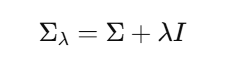

Where:
- Σ = sample covariance matrix
- λ = regularization parameter (small positive constant)
- I = identity matrix


In [ ]:
def Regularization(lamda,sharedCov):
  lambda_reg = lamda
  # Regularize covariance
  cov_reg = sharedCov + lambda_reg * np.eye(sharedCov.shape[0])
  # np.eye(Σ.shape[0]) → identity matrix of same size as Σ
  # ensures every diagonal element is at least λ
  # cov_reg is now guaranteed to be invertible and numerically stable
  return cov_reg


# **5. Prediction rule:**
• For a new input x:

• Compute, for each class k, a score proportional to:

log p(y = k | x) ∝ log π_k + log N(x ; μ_k, Σ_λ)

• You do not need the exact probability, only scores that are comparable across
classes.

• Predict the class k with the largest score.

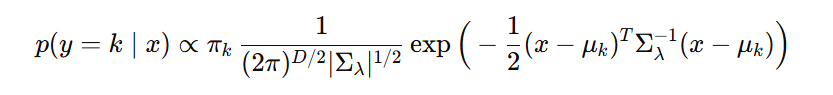
---
---
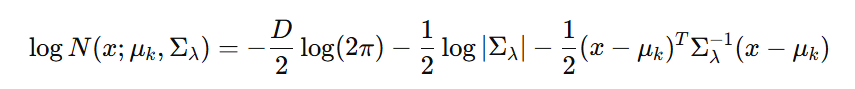

---

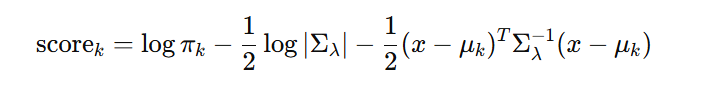

In [ ]:
def computeScore(x,mean,RegCov,prior):
  diff = x - mean
  diff = diff.reshape(-1,1)                       # to get the (x-mu) and (x-mu)T
  sign, logDeterminant = np.linalg.slogdet(RegCov) # to get the determinant of the covariance
  #The numpy.linalg.slogdet() function computes the sign and the natural logarithm of the absolute value of the determinant of an array.
  covInverse = np.linalg.inv(RegCov)
  #gets the inverse of the covariance
  score = np.log(prior) - 0.5 * logDeterminant - 0.5*diff.T @ covInverse @diff
  return score.item() #scalar instead of 1*1


In [ ]:
def predict(x,means,regCov,priors):
  # x: input feature vector to predict
  # means: array of all means of 10 classes
  # sigma: shared cov
  # priors: array of all priors of 10 classes
  scores=[]
  # loop over all 10 classes calculate the scores
  # the one with highest score is the prediction
  for Class in range (len(priors)):
    score = computeScore(x,means[Class],regCov,priors[Class])
    scores.append(score)

  # max-> will return the max out of scores
  # argmax-> will return the index corresponding to the max score(which is the class #)
  prediction = np.argmax(scores)
  return prediction

**A3. Hyperparameter Tuning and Evaluation**

Hyperparameter: λ (covariance regularization strength)

• λ controls how strong covariance regularisation is.

• If λ is too small, the covariance may be poorly conditioned, and the model may overfit.

• If λ is too large, the covariance becomes too “smooth” and the model may underfit.

In [ ]:
lamdas = [ 1e-4, 1e-3, 1e-2, 1e-1] # 1e-4 = 1*10^-4
n = len(lamdas)
accuracies = []
for i in range (n):
  reg_cov = Regularization(lamdas[i],sharedCov) #this would calculate the regularized cov
  predictions = []
  for j in range(len(x_valid)):
    predictions.append(predict(x_valid[j],meanOfClass,reg_cov,priorOfclass))
  accuracy = np.mean(predictions == y_valid)
  accuracies.append(accuracy)
  print("lamda = ",lamdas[i]," accurracy: ",accuracy)

#max-> will return the max accurracy I want the corresponding index
#which correspond to which lamda made the best accurracy
best_lamda = lamdas[np.argmax(accuracies)]
print("best Lamda: ",best_lamda)


lamda =  0.0001  accurracy:  0.9444444444444444
lamda =  0.001  accurracy:  0.9444444444444444
lamda =  0.01  accurracy:  0.9444444444444444
lamda =  0.1  accurracy:  0.9444444444444444
best Lamda:  0.0001


4. Final model:

• Combine the training and validation sets into a single training set.

• Retrain your Gaussian generative classifier on this combined set using the chosen
λ.

• Evaluate this final model on the test set only once.

In [ ]:
# now number of samples are 1527
xcombined_set = np.concatenate((x_train,x_valid),axis=0) # axis=0 concatenating: stacking rows under each other
# what was feature 0 in x_train under it feature 0 from x_valid
# combined_set.shape
y_combined = np.concatenate((y_train,y_valid),axis=0)

# Learning mean, priors, shared cov
priors_of_combined = estimate_Prior(y_combined,y_combined.shape[0])
means_of_combined = estimate_mean(xcombined_set,y_combined)
CombinedSharedCov = estimate_sharedCov(xcombined_set,y_combined,means_of_combined,y_combined.shape[0])
regularizedCov = Regularization(best_lamda,CombinedSharedCov)

# Evaluate this final model on the test set only once.
test_predictions=[]
for i in range(len(y_test)):
  test_predictions.append(predict(x_test[i],means_of_combined,regularizedCov,priors_of_combined))
accurracy = np.mean(test_predictions == y_test)
print(f"\nTest accuracy: {accurracy:.4f}")


Test accuracy: 0.9630


5.
• Test accuracy

• Macro-averaged precision

• Macro-averaged recall

• Macro-averaged F1-score

• The confusion matrix over the 10 digit classe

Accuracy: 0.9630
Macro Precision: 0.9632
Macro Recall: 0.9627
Macro F1-score: 0.9625


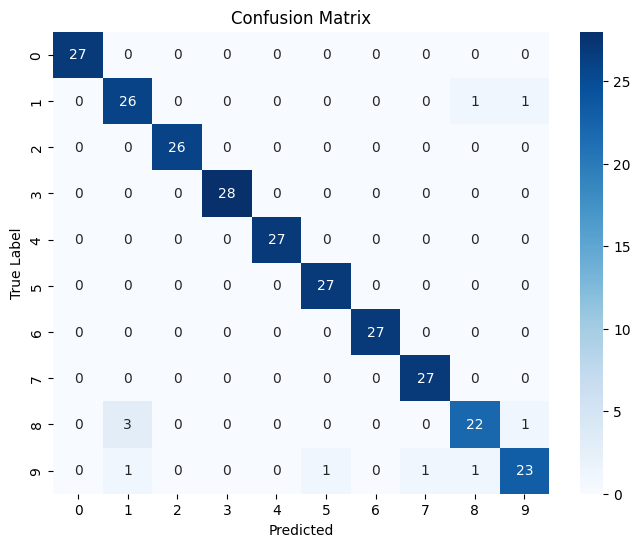

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

acc = accuracy_score(y_test,test_predictions)
macro_precision = precision_score(y_test,test_predictions,average="macro")
macro_recall = recall_score(y_test,test_predictions,average="macro")
macro_f1= f1_score(y_test,test_predictions,average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")


import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,test_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



# **A4.**

**1. Explanation:**

**1.1 Explanation of the Generative Model
Generative assumptions**

In a Gaussian Generative Classifier, we model two things:

1. The class prior

𝑝(𝑦=𝑘)=𝜋𝑘

We assume each class 𝑘
k has its own prior probability.
This is estimated simply as the the number of samples in class 𝑘/number of samples.

2. The class-conditional likelihood

𝑝(𝑥∣𝑦=𝑘)=𝑁(𝑥∣𝜇𝑘,Σ)

We assume that the data for each class follows a multivariate Gaussian distribution with:

its own mean vector 𝜇𝑘

a shared covariance matrix Σ
 across all classes (LDA assumption)

This means all classes have Gaussian shapes with different centers but the same spread.

**1.2. How you estimate the parameters π_k, μ_k, and Σ from the training data.**

we use the maximum likelihood estimation where we tru to get the parameters that lead to maximizing the likelihood

likelihood: it quantifies how good a distribution fits the data and if these paramaters fit the data (if it fits it well) then the observed data from the training data set will be more likely to occur

- simply: by getting the parameters that maximize the likelihood we are getting the parameters to make this distribution fit the observed data well

- prior:

$$P(C_k) = \frac{n_k}{n}$$

` # of samples that belong to class k over the total # of samples in the data set

- mean:

$$\hat{\boldsymbol{\mu}}_k = \frac{1}{n_k} \sum_{i: y_i = k} \mathbf{x}_i$$

  getting the mean across the features that belong to every class (DX1) summing all the samle points that belong to k class (every corresponding feature together over the total number of samples in a class)


- shared covariance:
$$\Sigma = \frac{1}{n} \sum_{i=1}^{n} (\mathbf{x}_i - \boldsymbol{\mu}_{y_i})(\mathbf{x}_i - \boldsymbol{\mu}_{y_i})^T$$


shared covariance: subtracting all of the samples vectors from the mean vector (which mean vector) the mean of a specific class that the sample vector belong to

**1.3. Why you need to regularize the covariance (Σ_λ = Σ + λ I) and what effect λ has.**

Normally, we regularize to make the parameters smaller so the model is simpler and does not ovefit

----

the covariance matrix Σ is estimated from data.
But when data is noisy or features are correlated:

Σ becomes unstable

Σ becomes non-invertible

The classifier overfits the training data

This is bad because the Gaussian formula needs Σ⁻¹

“Regularization is like preventing the model from trusting the training data too much.”

Here:

Σ without regularization trusts training correlations 100%

Σ + λI says: “don’t trust tiny variances or perfect correlations too much; add a little padding”



---

in addition of trying to make the model to not ovefit we are trying to prevent that the covariance matrix from being singular matrix (determinant=0) and will be non invertable that may happen due to multiple of reasons:
1. some features may have very small variance (spread) maybe the feature (pixel) have the same value over all the data samples which will make the varaince = 0 or small ... if small may lead to unstable calculations if it was diagonal then the inverse of the cov will be 1/variance squared which will be a huge #
2. correlated features that may make some of the rows scaler multiplication of the other which also makes the matrix singular with no inverse


**For each tested value of λ**

| Lambda | Accuracy |
|--------|----------|
| 0.0001 | 0.9444   |
| 0.001  | 0.9444   |
| 0.01   | 0.9444   |
| 0.1    | 0.9444   |

**Best Lambda:** 0.0001

**Summary of the final test results**

| Metric           | Score  |
|------------------|--------|
| Accuracy         | 0.9630 |
| Macro Precision  | 0.9632 |
| Macro Recall     | 0.9627 |
| Macro F1-score   | 0.9625 |

**Which digits are most often confused with each other.**

From the confusion matrix we can see that the confused numbers are:

- (1,9)
- (1,8)
- (5,9)
- (7,9)
- (8,9)

Regarding the effect of the regularization parameter λ, the performance was relatively stable across values of λ

**Any observations about the strengths and weaknesses of this Gaussian
generative model on the digits dataset**

Although our generative Gaussian classifier achieves high accuracy (~94%), it has inherent limitations.
First, it assumes that the features of each digit class follow a Gaussian distribution, which is an approximation and not strictly true for handwritten digits.

Second, by using a shared covariance matrix across all classes,we reduce the computaion from needing to compute O(D^2K) for the covariance for each class we only now need O(D^2) as well as we force the decision boundaries to be linear, which may not perfectly separate digits with similar shapes (e.g., 1 and 9).

Regularization (λ) helps ensure numerical stability, but if chosen incorrectly, it may underfit or overfit the data. Overall, these assumptions simplify computation but slightly reduce classification performance on certain confusing digits.

**Strengths:**  Generative Models on Small Datasets

Stronger assumptions help with small data

Generative models assume a specific distribution for each class (e.g., Gaussian).

This lets the model “fill in the gaps” when there are few training samples, because it doesn’t need to learn arbitrary decision boundaries.